# Linear mixed effects model benchmark

In [600]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from pymer4.models import Lmer
from itertools import product

In [98]:
# Load black for formatting
import jupyter_black

jupyter_black.load()
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [531]:
import warnings

warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")

## Read data and select variables

In [383]:
df = pd.read_parquet("../../data/runs/run_folder_2024-03-22_15.04/model_data.parquet")
df.head()

,SS,SSB,SSBS,Max_scaled_abundance_sqrt,Intercept,Primary vegetation_Light use,Primary vegetation_Intense use,Secondary vegetation_Minimal use,Secondary vegetation_Light use,Secondary vegetation_Intense use,Cropland_Minimal use,Cropland_Light_Intense,Pasture_Minimal use,Pasture_Light_Intense,Urban_All uses,Pop_density_1km_log,Road_density_50km_cbrt,Mean_pop_density_1km_log,Primary vegetation_Light use x Pop_density_1km_log,Primary vegetation_Intense use x Pop_density_1km_log,Secondary vegetation_Minimal use x Pop_density_1km_log,Secondary vegetation_Light use x Pop_density_1km_log,Secondary vegetation_Intense use x Pop_density_1km_log,Cropland_Minimal use x Pop_density_1km_log,Cropland_Light_Intense x Pop_density_1km_log,Pasture_Minimal use x Pop_density_1km_log,Pasture_Light_Intense x Pop_density_1km_log,Urban_All uses x Pop_density_1km_log,Primary vegetation_Light use x Road_density_50km_cbrt,Primary vegetation_Intense use x Road_density_50km_cbrt,Secondary vegetation_Minimal use x Road_density_50km_cbrt,Secondary vegetation_Light use x Road_density_50km_cbrt,Secondary vegetation_Intense use x Road_density_50km_cbrt,Cropland_Minimal use x Road_density_50km_cbrt,Cropland_Light_Intense x Road_density_50km_cbrt,Pasture_Minimal use x Road_density_50km_cbrt,Pasture_Light_Intense x Road_density_50km_cbrt,Urban_All uses x Road_density_50km_cbrt
0,AD1_2002__Tonhasca 1,AD1_2002__Tonhasca 1,AD1_2002__Tonhasca 1 5,0.674499,1,0,0,0,0,1,0,0,0,0,0,-0.205775,-0.898953,-1.440705,-0.000000,-0.0,-0.0,-0.0,-0.205775,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.898953,-0.0,-0.0,-0.0,-0.0,-0.0
1,AD1_2009__Vergara 1,AD1_2009__Vergara 1,AD1_2009__Vergara 1 15,0.902194,1,0,0,0,0,1,0,0,0,0,0,1.573487,-0.424551,0.975725,0.000000,0.0,0.0,0.0,1.573487,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.0,-0.0,-0.0,-0.424551,-0.0,-0.0,-0.0,-0.0,-0.0
2,AD1_2013__Grass 1,AD1_2013__Grass 1,AD1_2013__Grass 1 10,0.492175,1,0,0,0,0,0,0,0,0,0,0,-0.842682,0.166074,-0.973692,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,AD1_2013__Grass 1,AD1_2013__Grass 1,AD1_2013__Grass 1 12,0.764101,1,0,0,0,0,0,0,0,0,0,0,-0.770763,0.156382,-0.973692,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,AD1_2013__Grass 2,AD1_2013__Grass 2,AD1_2013__Grass 2 1,0.202640,1,1,0,0,0,0,0,0,0,0,0,-1.027548,0.301278,-0.973692,-1.027548,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,0.301278,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [264]:
df.shape

(7717, 39)

In [589]:
# R doesn't like blanks in column headers
df.columns = df.columns.str.replace(" ", "_")

response = "Max_scaled_abundance_sqrt"
groups = ["SS", "SSB"]

# Create list of all covariates to be used
fe_vars = [
    col
    for col in df.columns
    if col not in ["Intercept", "SS", "SSB", "SSBS", "Max_scaled_abundance_sqrt"]
]

## Model training and prediction

In [583]:
def fit_lme_model(df, response, fe_vars, re_vars, independent_re=False):
    fe_formula = " + ".join(fe_vars)

    if independent_re:
        re_study_formula = f"({' + '.join(re_vars)}|SS)"
        re_block_formula = f"({' + '.join(re_vars)}|SSB)"
    else:
        re_study_formula = " + ".join(f"({var}|SS)" for var in re_vars)
        re_block_formula = " + ".join(f"({var}|SSB)" for var in re_vars)

    re_study_formula = " + ".join(f"({var}|SS)" for var in random_slope_vars)
    formula = f"{response} ~ {fe_formula} + {re_study_formula} + {re_block_formula}"

    model = Lmer(formula, data=df)
    model.fit(conf_int="Wald", summary=False, REML=True)

    return model

In [598]:
model = fit_lme_model(df, response, fe_vars, re_vars=None, independent_re=False)

In [599]:
print(model.summary())

Linear mixed model fit by REML [’lmerMod’]
Formula: Max_scaled_abundance_sqrt~Primary_vegetation_Light_use+Primary_vegetation_Intense_use+Secondary_vegetation_Minimal_use+Secondary_vegetation_Light_use+Secondary_vegetation_Intense_use+Cropland_Minimal_use+Cropland_Light_Intense+Pasture_Minimal_use+Pasture_Light_Intense+Urban_All_uses+Pop_density_1km_log+Road_density_50km_cbrt+Mean_pop_density_1km_log+Primary_vegetation_Light_use_x_Pop_density_1km_log+Primary_vegetation_Intense_use_x_Pop_density_1km_log+Secondary_vegetation_Minimal_use_x_Pop_density_1km_log+Secondary_vegetation_Light_use_x_Pop_density_1km_log+Secondary_vegetation_Intense_use_x_Pop_density_1km_log+Cropland_Minimal_use_x_Pop_density_1km_log+Cropland_Light_Intense_x_Pop_density_1km_log+Pasture_Minimal_use_x_Pop_density_1km_log+Pasture_Light_Intense_x_Pop_density_1km_log+Urban_All_uses_x_Pop_density_1km_log+Primary_vegetation_Light_use_x_Road_density_50km_cbrt+Primary_vegetation_Intense_use_x_Road_density_50km_cbrt+Secondar

In [570]:
# Make predictions with and without random effects
pred_only_fe = model.predict(
    df, use_rfx=False, skip_data_checks=True, verify_predictions=False
)
pred_with_re = model.predict(
    df, use_rfx=True, skip_data_checks=True, verify_predictions=False
)
# Get the true values
y_true = df["Max_scaled_abundance_sqrt"]

In [486]:
def inverse_transform_response(y: np.array, method: str) -> np.array:
    """Add docstring."""
    if method == "logit":
        res = expit(y)
    elif method == "sqrt":
        res = np.square(y)
    else:
        res = y

    return res

In [553]:
def calculate_marginal_and_conditional_r2(y_true, pred):
    r2 = np.var(pred) / np.var(y_true)

    return r2

In [487]:
# Rescale true and predicted values to original scale
# NOTE: Produces terrible R2 results; they probably didn't do this scaling

transform = "sqrt"

y_true = inverse_transform_response(y_true, transform)
pred_only_fe = inverse_transform_response(pred_only_fe, transform)
pred_with_re = inverse_transform_response(pred_with_re, transform)

## Plot outputs

In [547]:
def plot_predictions_and_residuals(y_true: np.array, y_pred: np.array) -> None:
    """
    Plots various visualizations to analyze regression model results.
    - The first plot is a scatter plot of predictions and actuals.
    - Second plot shows all residual values.
    - Third plot shows residuals as a density graph.
    """

    r2 = calculate_marginal_and_conditional_r2(y_true, y_pred)

    # Scatter plot of predictions vs actuals
    plt.figure(figsize=(8, 4))
    plt.scatter(y_true, y_pred, alpha=0.2)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "--k", linewidth=1)
    plt.text(0.05, 0.95, f"R² = {r2:.3f}", fontsize=12, transform=plt.gca().transAxes)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.title("Predictions vs actuals")
    plt.grid(True)
    plt.show()

    # Residuals vs actual scatter plot
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 4))
    plt.scatter(y_true, residuals, alpha=0.2)
    plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
    plt.xlabel("Actual values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs actual values")
    plt.grid(True)
    plt.show()

    # Residual Density Plot (Distribution of Residuals)
    plt.figure(figsize=(8, 4))
    sns.kdeplot(residuals, fill=True)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title("Residual density Plot")
    plt.grid(True)
    plt.show()

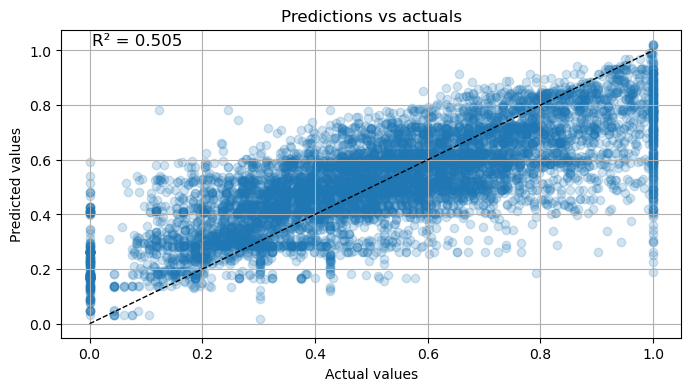

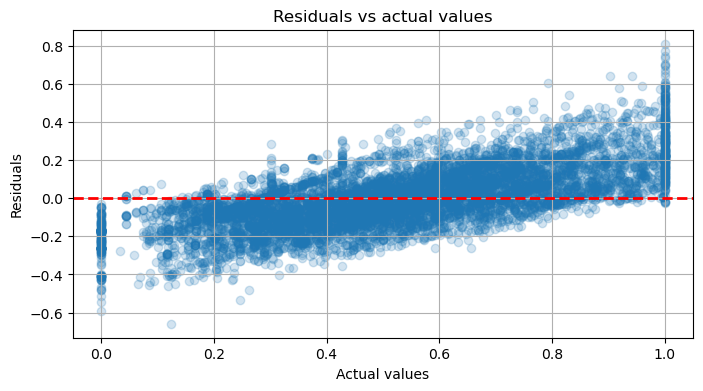

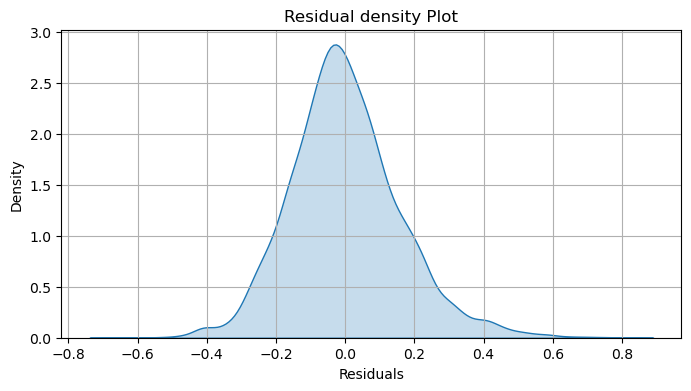

In [571]:
# Plot with predictions including RE
plot_predictions_and_residuals(y_true, pred_with_re)

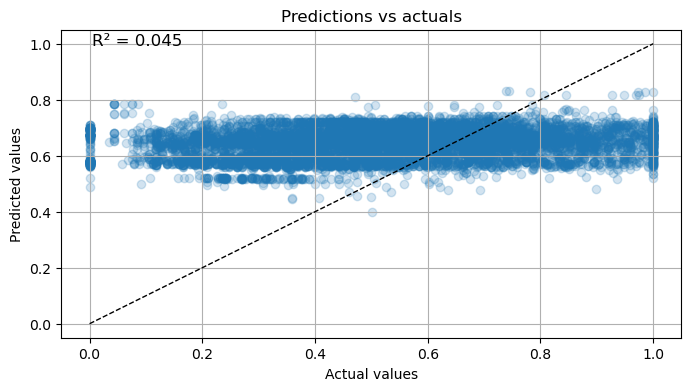

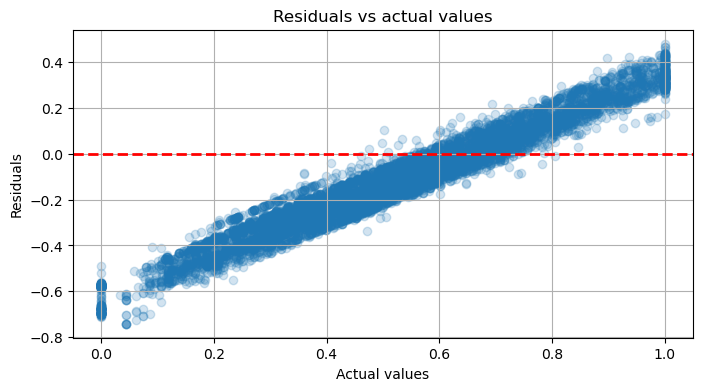

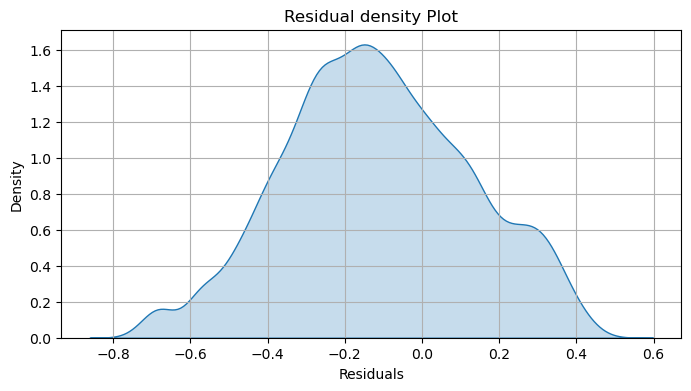

In [572]:
# Plot with predictions including RE
plot_predictions_and_residuals(y_true, pred_only_fe)

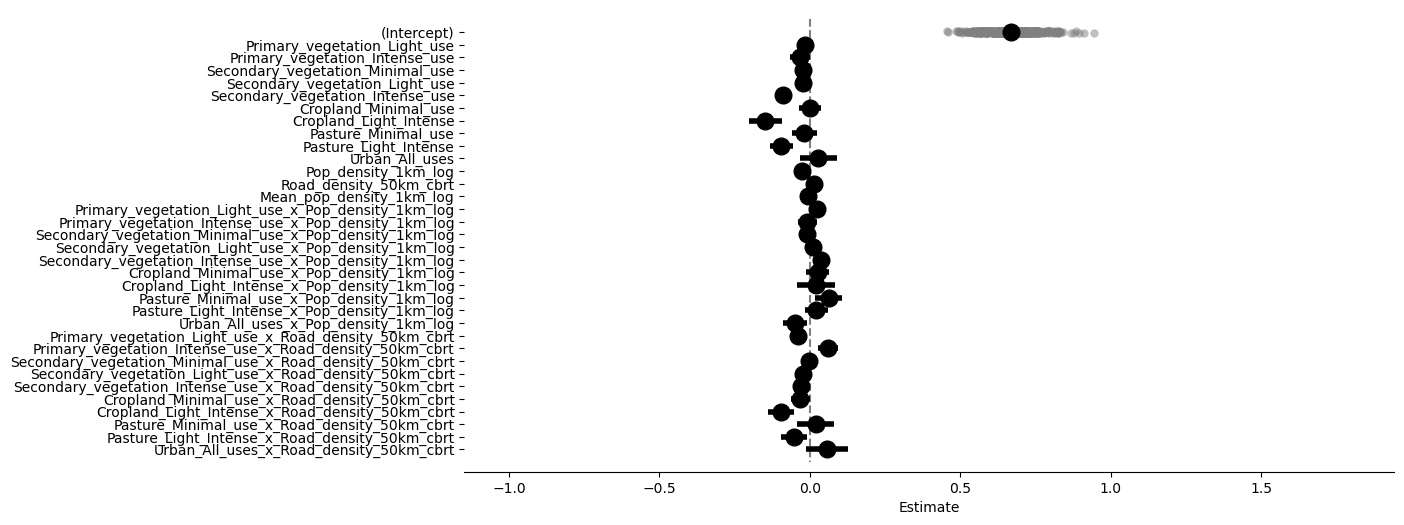

In [484]:
model.plot_summary();

## Testing random slope models

In [597]:
def fit_lme_model(df, response, fe_vars, re_vars=None, independent_re=False):
    fe_formula = " + ".join(fe_vars)

    if re_vars:
        if independent_re:
            re_study_formula = f"({' + '.join(re_vars)}|SS)"
            re_block_formula = f"({' + '.join(re_vars)}|SSB)"
        else:
            re_study_formula = " + ".join(f"({var}|SS)" for var in re_vars)
            re_block_formula = " + ".join(f"({var}|SSB)" for var in re_vars)

        formula = f"{response} ~ {fe_formula} + {re_study_formula} + {re_block_formula}"

    else:
        formula = f"{response} ~ {fe_formula} + (1|SS) + (1|SSB)"

    model = Lmer(formula, data=df)
    model.fit(conf_int="Wald", summary=False, REML=True)

    return model

In [594]:
re_vars = covariates[:2]

In [595]:
def select_random_slopes(df, response, fe_vars, re_vars):

    base_model_aic = fit_lme_model(
        df, response, fe_vars, re_vars=None, independent_re=False
    ).AIC

    re_candidates = []
    for var in fe_vars:
        candidate_model_aic = fit_lme_model(
            df, response, fe_vars, re_vars, independent_re=False
        ).AIC
        
        if candidate_model_aic > base_model_aic:
            re_candidates.append(var)

        if re_candidates:  # Check that the dict is not empty
            
                

## Cross-validation

In [394]:
# NOTE: Not used for the LME

def create_stratification_column(
    df: pd.DataFrame, stratify_groups: list[str]
) -> pd.DataFrame:
    """
    Create a new column for stratification by concatenating the
    specified group columns.
    """

    if len(stratify_groups) > 1:
        df["Stratify_group"] = df[stratify_groups].astype(str).agg("_".join, axis=1)
    else:
        df["Stratify_group"] = df[stratify_groups[0]]

    return df

In [516]:
def generate_kfolds(
    df: pd.DataFrame,
    y_var: str,
    x_vars: list[str],
    groups: list[str],
    k: int = 5,
    stratify: bool = False,
) -> tuple[list[pl.DataFrame], list[pl.DataFrame], list[pl.Series], list[pl.Series]]:

    # Lists for storing the train and test datasets
    x_train_list = []
    x_test_list = []
    y_train_list = []
    y_test_list = []
    group_train_list = []
    group_test_list = []

    # Set up stratified k-fold sampler object and sample using the
    # stratify code (as the "y class label") for stratification
    if stratify:
        kfold = StratifiedKFold(n_splits=k, shuffle=True)
        strat_col = df.get_column("Stratify_group")
    else:
        kfold = KFold(n_splits=k, shuffle=True)
        strat_col = None

    for train_index, test_index in kfold.split(X=df, y=strat_col):
        x_train, x_test = df.iloc[train_index][x_vars], df.iloc[test_index][x_vars]
        y_train, y_test = df.iloc[train_index][y_var], df.iloc[test_index][y_var]
        group_train, group_test = (
            df.iloc[train_index][groups],
            df.iloc[test_index][groups],
        )

        # Store the data for this fold
        x_train_list.append(x_train)
        x_test_list.append(x_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)
        group_train_list.append(group_train)
        group_test_list.append(group_test)

    return (
        x_train_list,
        x_test_list,
        y_train_list,
        y_test_list,
        group_train_list,
        group_test_list,
    )

In [517]:
# Generate folds
(
    x_train_list,
    x_test_list,
    y_train_list,
    y_test_list,
    group_train_list,
    group_test_list,
) = generate_kfolds(
    df,
    y_var=response,
    x_vars=covariates,
    groups=groups,
    k=5,
    stratify=False,
)

In [539]:
def run_lme_cross_validation(
    df,
    response: str,
    covariates: list[str],
    x_train_list,
    x_test_list,
    y_train_list,
    y_test_list,
    group_train_list,
    group_test_list,
):

    for i in range(len(x_train_list)):
        # Get the train and test data
        x_train, x_test = x_train_list[i], x_test_list[i]
        y_train, y_test = y_train_list[i], y_test_list[i]
        group_train, group_test = group_train_list[i], group_test_list[i]

        # Merge in order to fit structure of Pymer4 LME model, and fit the model
        df_train = pd.concat([group_train, y_train, x_train], axis="columns")
        df_test = pd.concat([group_test, y_test, x_test], axis="columns")
        model = fit_lme_model(df_train, response=response, covariates=covariates)

        # Make predictions on the training set
        pred_fe_train = model.predict(
            df_train, use_rfx=False, skip_data_checks=True, verify_predictions=False
        )
        pred_train = model.predict(
            df_train, use_rfx=True, skip_data_checks=True, verify_predictions=False
        )

        # Make predictions on the test set
        pred_fe_test = model.predict(
            df_test, use_rfx=False, skip_data_checks=True, verify_predictions=False
        )
        pred_test = model.predict(
            df_test, use_rfx=True, skip_data_checks=True, verify_predictions=False
        )

        # Compute R2 scores and evaluate
        cond_r2_train = calculate_marginal_and_conditional_r2(y_train, pred_train)
        marg_r2_train = calculate_marginal_and_conditional_r2(y_train, pred_fe_train)

        cond_r2_test = calculate_marginal_and_conditional_r2(y_test, pred_test)
        marg_r2_test = calculate_marginal_and_conditional_r2(y_test, pred_fe_test)

        print(f"Fold {i + 1} results:")
        print(
            f"Conditional R2: {round(cond_r2_train, 3)} (train) {round(cond_r2_test, 3)} (test)"
        )
        print(
            f"Marginal R2: {round(marg_r2_train, 3)} (train) {round(marg_r2_test, 3)} (test)\n"
        )

In [573]:
# Run the cross validation and print results
run_lme_cross_validation(
    df,
    response,
    covariates,
    x_train_list,
    x_test_list,
    y_train_list,
    y_test_list,
    group_train_list,
    group_test_list,
)

Fold 1 results:
Conditional R2: 0.499 (train) 0.487 (test)
Marginal R2: 0.043 (train) 0.044 (test)

Fold 2 results:
Conditional R2: 0.499 (train) 0.491 (test)
Marginal R2: 0.049 (train) 0.05 (test)

Fold 3 results:
Conditional R2: 0.502 (train) 0.486 (test)
Marginal R2: 0.049 (train) 0.049 (test)

Fold 4 results:
Conditional R2: 0.504 (train) 0.487 (test)
Marginal R2: 0.046 (train) 0.045 (test)

Fold 5 results:
Conditional R2: 0.499 (train) 0.505 (test)
Marginal R2: 0.044 (train) 0.045 (test)

